<a href="https://colab.research.google.com/github/adamehayman/AMII/blob/main/2_Decision_Tree_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Decision Tree Classifier Introduction**  
  
Although decision trees may not be the fanciest algorithms out there, they are still a useful tool to visualize the decision-making process. They provide insights into which features are dominating the decisions and results.  
In this example, we wil try to predict 10 different classes, which the emphasis on those that are closer to the actual RUL, as that aligns with our business objective.  
We will import the dataframes from the EDA process in the previous notebook.

In [1]:
import numpy as np # for numeric computation
import pandas as pd # for handling data in table format
pd.set_option('display.max_rows', 200)
import requests # for retrieving web addresses
import io # for storing data
import plotly.express as px # for visualization
import math
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')

## **Import Data**

In [2]:
# Clone Git Repo
!git clone -l -s git://github.com/adamehayman/AMII.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 69 (delta 30), reused 47 (delta 16), pack-reused 0
Receiving objects: 100% (69/69), 15.11 MiB | 15.48 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/cloned-repo
1_NASA_FD001_EDA.ipynb		  FIgures.pptx	      README.md
2_Decision_Tree_Classifier.ipynb  NASA_TurboFan_Data


In [3]:
train1_class = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/train1_new.csv')
test1_class = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/test1.csv')

In [4]:
sensor2keep = ['T24', 'T30', 'T50', 'P15', 'P30', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'w31', 'w32']
col2keep = ['Unit', 'T24', 'T30', 'T50', 'P15', 'P30', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'w31', 'w32', 'RUL']

In [5]:
test1_class = test1_class[col2keep]

## **Data Visualization**  
  
Plots of every 10th unit for the two most strongly correlated sensors with RUL, Ps30 and T50

In [6]:
# Strongest Negative Correlation from previous EDA notebook

str_corr = ['Ps30', 'T50']

In [7]:
# Function to plot every 10th unit

def plot_sensor(sensor_name):
    plt.figure(figsize=(20,5))
    for i in train1_class['Unit'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train1_class[train1_class['Unit']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

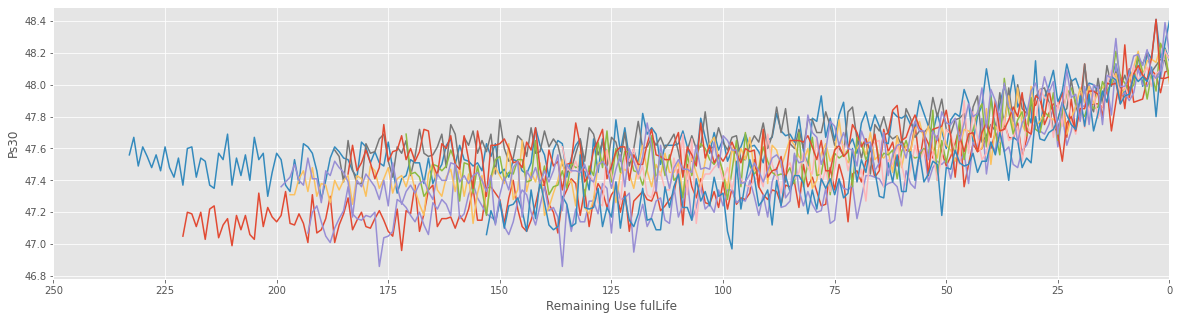

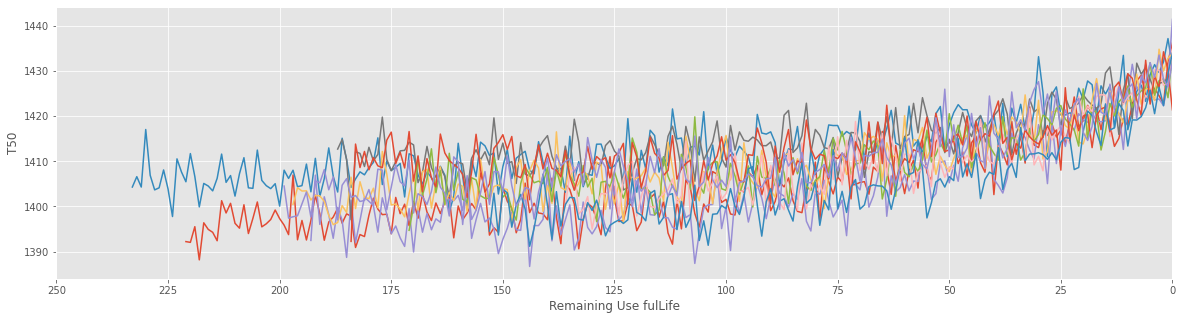

In [8]:
for sensor_name in str_corr:
    plot_sensor(sensor_name)

## **Label Data Discretization - Creating RUL Classes or Bins for train1 and test1**  

As we saw in the previous notebook, 2_10_Class_Decision_Tree_Classifier, the model had a difficult time distinguishing between classes 5 to 10. We will try focusing on when the degradation begins.  
  
class 1 = RUL 0-20    
class 2 = RUL 20-40  
class 3 = RUL 40-60    
class 4 = RUL 60-80    
class 5 = RUL > 80

## **Original Split from previous notebook**
# 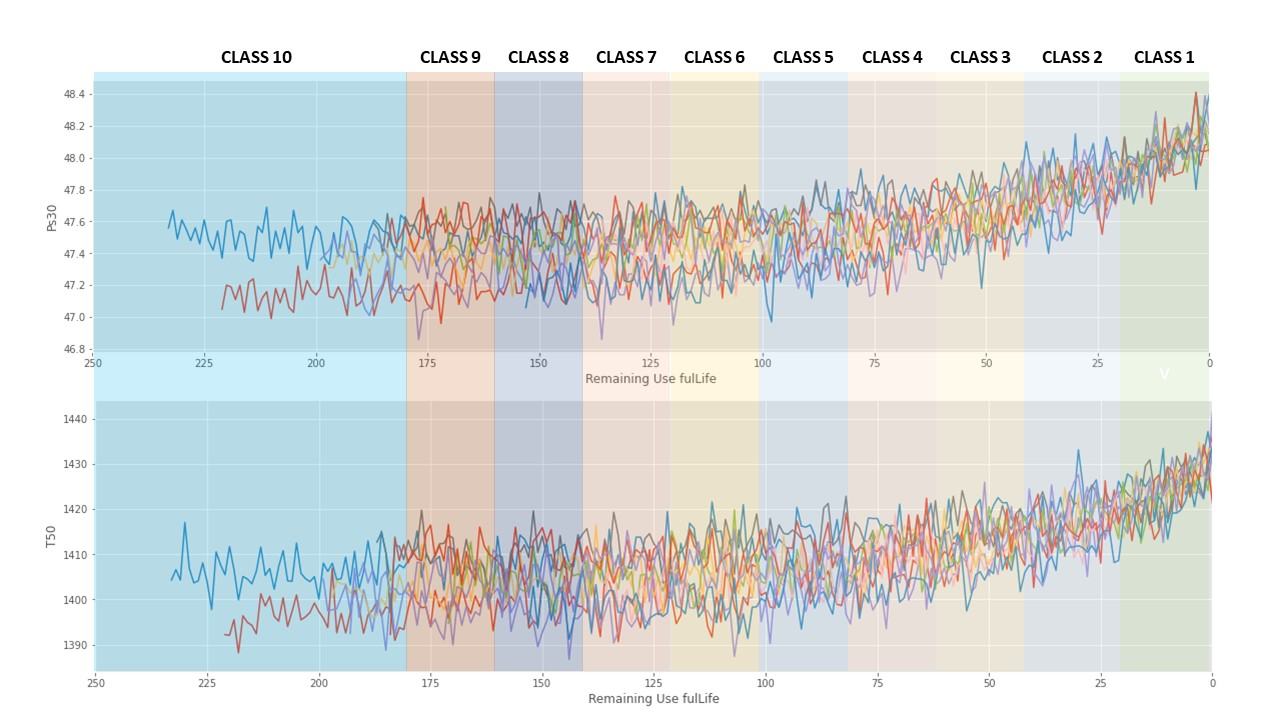

## **New Split based on degradation**
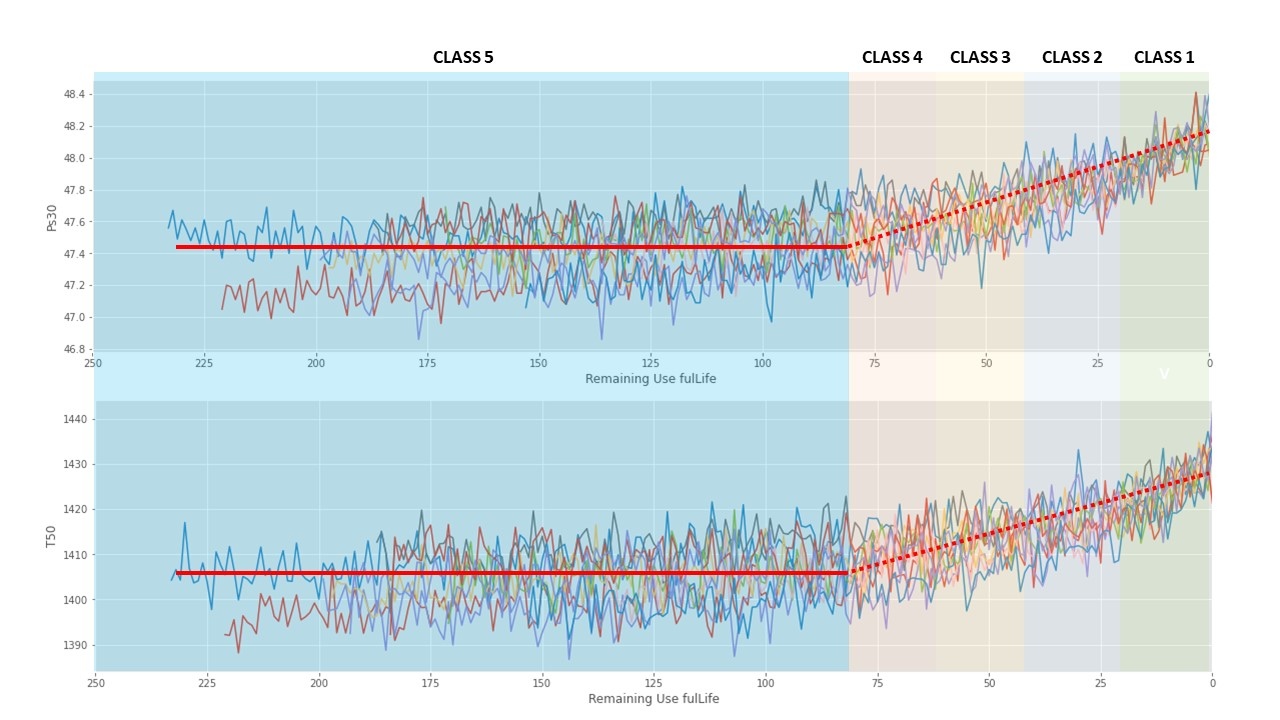

The above graph illustrates why our previous model had difficulties distinguishing between classes 5-10. We will now focus more on the classes where the degradation began to accelerate.

### **train1_class**

In [9]:
for ii in range(len(train1_class)):

    curr_RUL = train1_class.loc[ii, 'RUL']

    if curr_RUL >= 0 and curr_RUL < 20:
        train1_class.loc[ii, 'RUL class'] = int(1)
    elif curr_RUL >= 20 and curr_RUL < 40:
        train1_class.loc[ii, 'RUL class'] = int(2)
    elif curr_RUL >= 40 and curr_RUL < 60:
        train1_class.loc[ii, 'RUL class'] = int(3)
    elif curr_RUL >= 60 and curr_RUL < 80:
        train1_class.loc[ii, 'RUL class'] = int(4)
    else:
        train1_class.loc[ii, 'RUL class'] = int(5)

In [10]:
train1_class['RULclass'] = train1_class['RUL class'].astype(int)
train1_class.drop('RUL class', axis=1, inplace=True)

### **test1_class**

In [11]:
for ii in range(len(test1_class)):

    curr_RUL = test1_class.loc[ii, 'RUL']

    if curr_RUL >= 0 and curr_RUL < 20:
        test1_class.loc[ii, 'RUL class'] = int(1)
    elif curr_RUL >= 20 and curr_RUL < 40:
        test1_class.loc[ii, 'RUL class'] = int(2)
    elif curr_RUL >= 40 and curr_RUL < 60:
        test1_class.loc[ii, 'RUL class'] = int(3)
    elif curr_RUL >= 60 and curr_RUL < 80:
        test1_class.loc[ii, 'RUL class'] = int(4)
    else:
        test1_class.loc[ii, 'RUL class'] = int(5)

In [12]:
test1_class['RULclass'] = test1_class['RUL class'].astype(int)
test1_class.drop('RUL class', axis=1, inplace=True)

### **RULclass Distribution**  
Examine the RULclass distribution so we can create bins for StratifiedShuffleSplit

In [13]:
fig = px.histogram(train1_class, x='RULclass')
fig.show()

In [14]:
train1_class['RULclass'].value_counts()

5    12631
4     2000
3     2000
2     2000
1     2000
Name: RULclass, dtype: int64

From the above class distribution, we can see we have an imbalanced dataset, as expected.
Since we made a RULclass column, we will also have to drop the RUL column or the algorithm will simply use that to predict the RULclass. We will also drop the Unit column as that could lead to invalid predictions. We will also drop the columns that we discovered, from the last notebook, will likely provide little insight.

In [15]:
train1_class.drop(['RUL', 'Unit', 'P15', 'NRc'], axis=1, inplace=True)

In [16]:
train1_class.reset_index(drop=True, inplace=True)

In [17]:
test1_class.drop(['RUL', 'Unit', 'P15', 'NRc'], axis=1, inplace=True)

In [18]:
test1_class.reset_index(drop=True, inplace=True)

## **Imbalanced Dataset**  
  
We will implement a few different techniques to tackle our imbalanced dataset. We will be using the Imbalanced-learn library (https://imbalanced-learn.org/)  

In [19]:
pip install -U imbalanced-learn

     |████████████████████████████████| 174kB 8.9MB/s 
     |████████████████████████████████| 22.2MB 1.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


### **ADASYN: Adaptive synthetic sampling approach for imbalanced learning**  
  
How ADASYN is implemented:  
  
1.  calculate the ratio of minority to majority examples
2.  calculate the total number of synthetic data to generate
3.  find the k-Nearest neighbors of each minority example and calculate the rᵢ value. After this step, each minority example will be asscociated with a different neighborhood. The rᵢ value indicates the dominance of the majority class in each specific neighborhood. Higher rᵢ neighbourhoods contain more majority class examples and are more difficult to learn.
4.  Normalize the rᵢ values so that the sum of all rᵢ values equals to 1.
5.  Calculate the amount of synthetic examples to generate per neighbourhood. Because rᵢ is higher for neighbourhoods dominated by majority class examples, more synthetic minority class examples will be generated for those neighbourhoods. Hence, this gives the ADASYN algorithm its adaptive nature; more data is generated for “harder-to-learn” neighbourhoods.
6.  Generate Gᵢ data for each neighbourhood. First, take the minority example for the neighbourhood, xᵢ. Then, randomly select another minority example within that neighbourhood, xzᵢ.

In [20]:
from imblearn.over_sampling import ADASYN

In [21]:
X_train_adasyn = train1_class.drop(['RULclass'], axis=1)
y_train_adasyn = train1_class['RULclass'].copy()

In [22]:
ada = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train_adasyn, y_train_adasyn)

In [23]:
fig = px.histogram(y_train_adasyn, x='RULclass')
fig.show()

In [24]:
y_train_adasyn.value_counts()

1    12834
3    12720
5    12631
4    12547
2    12414
Name: RULclass, dtype: int64

### **Recombine data into DataFrame before shuffle split**

In [25]:
ADASYN_df = pd.concat([X_train_adasyn, y_train_adasyn], axis=1)

## **Stratified-Shuffle Split**

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

In [27]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(ADASYN_df, ADASYN_df['RULclass']):
  ADASYN_train = ADASYN_df.loc[train_index]
  ADASYN_val = ADASYN_df.loc[test_index]

In [28]:
StratSplit = ADASYN_val['RULclass'].value_counts() / len(ADASYN_val)
Dist = ADASYN_df['RULclass'].value_counts() / len(ADASYN_df)

Create a DataFrame to compare the actual distribution of RULclass vs the distribution obtained form StratifiedShuffleSplit

In [29]:
df_Compare = pd.DataFrame(columns = ['Stratified Split', 'Actual Distribution', 'Difference'])
df_Compare['Stratified Split'] = StratSplit
df_Compare['Actual Distribution'] = Dist
df_Compare['Difference'] = StratSplit - Dist
df_Compare

Stratified Split  Actual Distribution  Difference
1          0.203246             0.203243    0.000003
3          0.201425             0.201438   -0.000013
5          0.200000             0.200029   -0.000029
4          0.198733             0.198698    0.000035
2          0.196595             0.196592    0.000003

In [30]:
print('Our training set is ADASYN_train with shape: ' + str(ADASYN_train.shape) + '\n'
'Our validation set is ADASYN_val with shape: ' + str(ADASYN_val.shape))

Our training set is ADASYN_train with shape: (50516, 12)
Our validation set is ADASYN_val with shape: (12630, 12)


## **Preapre the Data for Machine Learning Algorithms**

In [31]:
sensors = ['T24', 'T30', 'T50', 'P30', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'w31', 'w32']

In [32]:
X_train = ADASYN_train.drop('RULclass', axis=1)
y_train = ADASYN_train['RULclass'].copy()

In [33]:
X_val = ADASYN_val.drop('RULclass', axis=1)
y_val = ADASYN_val['RULclass'].copy()

We will scale the data using MinMax scaler as that produced slightly better results from the previous notebook.

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()

It may seem trivial to some, but we will fit_transform the training set only and fit that function to both the validation and test sets to prevent data leakage.

In [35]:
X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)

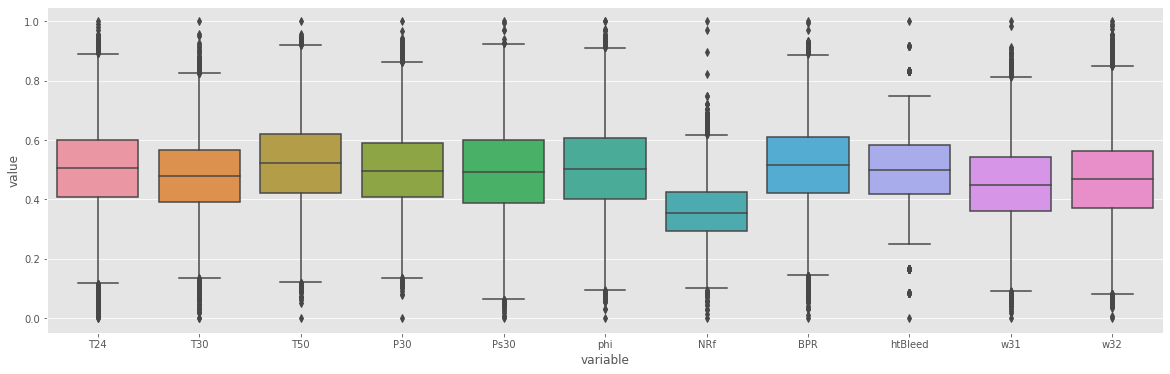

In [36]:
train1_minmax = pd.DataFrame(X_train_scaled, columns = sensors)
plt.figure(figsize=(20, 6))
sns.boxplot(x="variable", y="value", data=pd.melt(train1_minmax))
plt.show()

## **Train Classification Tree**

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, r2_score, precision_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_squared_error

In [38]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

### **MinMax Classification Tree**

In [39]:
DTCmin = DecisionTreeClassifier(random_state=42)

DTCmin.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

In [40]:
yhat_train = DTCmin.predict(X_train_scaled)
evaluate(y_train, yhat_train, 'train')

train set RMSE:0.0, R2:1.0


In [41]:
yhat_val = DTCmin.predict(X_val_scaled)
evaluate(y_val, yhat_val, 'val')

val set RMSE:0.759005057790385, R2:0.7131453300096446


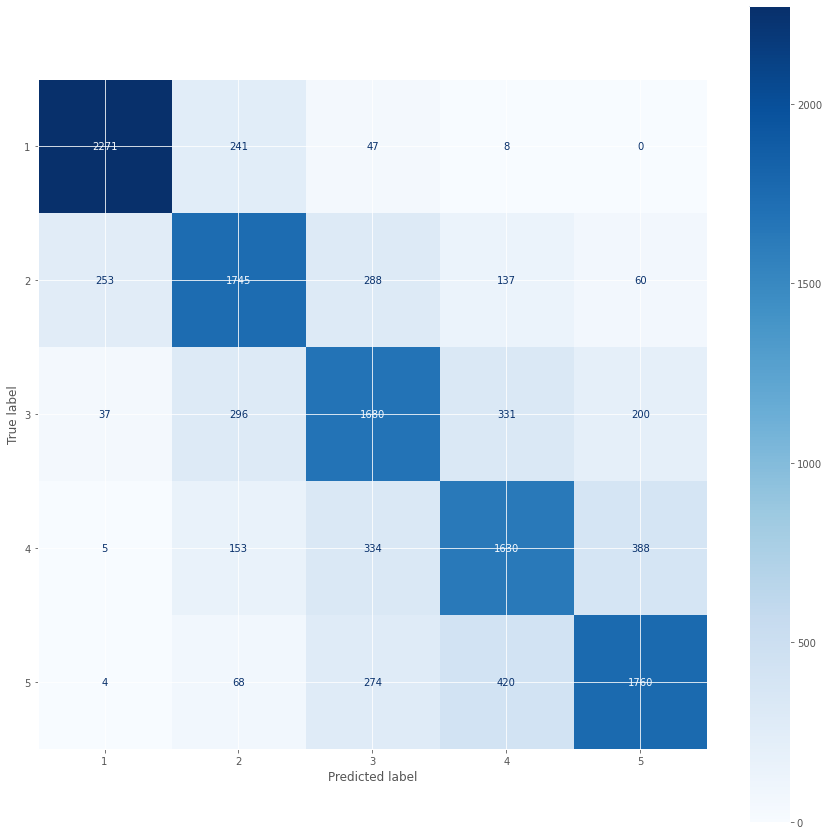

In [42]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(DTCmin, X_val_scaled, y_val, cmap=plt.cm.Blues, ax=ax)

In [43]:
precision, recall, fscore, support = score(y_val, yhat_val)

print('precision on val: {}'.format(precision))
print('recall on val: {}'.format(recall))
print('fscore on val: {}'.format(fscore))
print('support on test: {}'.format(support))

precision on val: [0.88365759 0.6971634  0.64048799 0.64528899 0.73089701]
recall on val: [0.8846903  0.7027789  0.66037736 0.64940239 0.69675376]
fscore on val: [0.88417364 0.69995989 0.65028063 0.64733916 0.71341711]
support on test: [2567 2483 2544 2510 2526]


#### **MinMax GridSearch**

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
param_dict = {
    'criterion':['gini', 'entropy'],
    'max_depth':range(1, 10),
    'min_samples_split':range(1,10),
    'min_samples_leaf':range(1,5)
}

In [47]:
DTCminGrid = GridSearchCV(DTCmin,
                          param_grid=param_dict,
                          cv=5,
                          verbose=1,
                          n_jobs=-1)
DTCminGrid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10)},
             verbose=1)

In [48]:
DTCminGrid.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [49]:
DTCminGrid.best_estimator_

DecisionTreeClassifier(max_depth=9, random_state=42)

In [50]:
DTCminGrid.best_score_

0.568671217732102

In [51]:
DTCminScore = DTCminGrid.best_score_

### **Accuracy Comparison between 10 class tree and 5 class tree with ADASYN**

In [52]:
print('MinMax Scaled Decision Tree Classifier Score:',DTCminScore)

MinMax Scaled Decision Tree Classifier Score: 0.568671217732102


The 10 class tree from the previous note book had an accuracy of 29.9%.  
The 5 class tree with ADASYN has an accuracy of 56.9%.

## **Dimensionality Reduction**  
  
First, we will create a new dataframe from the original train1_class dataframe. We will take a representative sample for visualization purposes using Scikit_Learn stratified sample split, 10%.

### **Plotting Functions**

In [53]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import plotly.io as plt_io
import plotly.graph_objects as go
import time

In [54]:
PCA_df = ADASYN_df

In [55]:
# Create a 10% representative subsample
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 42)
for train_index, test_index in split.split(PCA_df, PCA_df['RULclass']):
  PCA_train = PCA_df.loc[train_index]
  PCA_val = PCA_df.loc[test_index]

In [56]:
X_PCA = PCA_val.drop(['RULclass'], axis=1)
y_PCA = PCA_val['RULclass'].copy()

In [57]:
def plot_2d(component1, component2):
    
    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode='markers',
        marker=dict(
            size=20,
            color=y_PCA, #set color equal to a variable
            colorscale='Rainbow', # one of plotly colorscales
            showscale=True,
            line_width=1
        )
    ))
    fig.update_layout(margin=dict( l=100,r=100,b=100,t=100),width=1500,height=800)                 
    fig.layout.template = 'plotly_dark'
    
    fig.show()

In [58]:
def plot_3d(component1,component2,component3):

    fig = go.Figure(data=[go.Scatter3d(
        x=component1,
        y=component2,
        z=component3,
        mode='markers',
        marker=dict(
            size=10,
            color=y_PCA,                # set color to an array/list of desired values
            colorscale='Rainbow',   # choose a colorscale
            opacity=1,
            line_width=1
        )
    )])
# tight layout
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1500,height=800)
    fig.layout.template = 'plotly_dark'
    
    fig.show()

### **PCA (Principal Component Analysis)**  

PCA works by identifying the hyperplane that lies closest to the data and then projects the data on that hyperplane while retaining most of the dataset variation.  
We will do some PCA visualization to see how our RUL classes are clustered.

In [59]:
start = time.time()
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_PCA)
print('Duration: {} seconds'.format(time.time() - start))
principal = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

Duration: 0.053025007247924805 seconds


#### **2D PCA**

In [60]:
plot_2d(principalComponents[:, 0],principalComponents[:, 1])

#### **3D PCA**

In [61]:
plot_3d(principalComponents[:, 0],principalComponents[:, 1],principalComponents[:, 2])

#### **Plotly PCA**

In [62]:
pca = PCA(n_components=3)
components = pca.fit_transform(X_PCA)

In [63]:
total_var = pca.explained_variance_ratio_.sum() * 100

In [64]:
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_PCA,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

We can see a bit of a trend in the RULclass, but no clear separation of clusters

### **t-SNE (T-distributed stochastic neighbor embedding)**  
  
(t-SNE) takes a high dimensional data set and reduces it to a low dimensional graph that retains a lot of the original information. It does so by giving each data point a location in a two or three-dimensional map. This technique finds clusters in data, thereby ensuring that an embedding preserves the meaning in the data. t-SNE reduces dimensionality while keeping similar instances close and dissimilar instances apart.

In [65]:
start = time.time()
pca_3 = PCA(n_components=3)
pca_result_3 = pca_3.fit_transform(X_PCA)
tsne = TSNE(random_state = 42, n_components=3,verbose=0, perplexity=40, n_iter=400).fit_transform(pca_result_3)
print('Duration: {} seconds'.format(time.time() - start))

Duration: 72.87887334823608 seconds


#### **2D t-SNE**

In [66]:
plot_2d(tsne[:, 0],tsne[:, 1])

#### **3D t-SNE**

In [67]:
plot_3d(tsne[:, 0],tsne[:, 1],tsne[:, 2])

### **LDA (Linear Discriminant Analysis)**  
  
Linear Discriminant Analysis (LDA) is most commonly used as a dimensionality reduction technique in the pre-processing step for pattern-classification.
The goal is to project a dataset onto a lower-dimensional space with good class-separability to avoid overfitting and reduce computational costs.

In [68]:
start = time.time()
X_LDA = LDA(n_components=3).fit_transform(X_PCA,y_PCA)
print('Duration: {} seconds'.format(time.time() - start))

Duration: 0.05179619789123535 seconds


#### **2D LDA**

In [69]:
plot_2d(X_LDA[:, 0],X_LDA[:, 1])

#### **3D LDA**

In [70]:
plot_3d(X_LDA[:, 0],X_LDA[:, 1],X_LDA[:, 2])

### **UMAP (Uniform Manifold Approximation and Projection)**  
  
UMAP is a nonlinear dimensionality reduction method; it helps visualize clusters or groups of data points and their relative proximities.
UMAP is similar to t-SNE but with probably higher processing speed, therefore, faster and better visualization.

In [71]:
start = time.time()
reducer = umap.UMAP(random_state=42,n_components=3)
embedding = reducer.fit_transform(X_PCA)
print('Duration: {} seconds'.format(time.time() - start))

Duration: 39.05125141143799 seconds


#### **2D UMAP**

In [72]:
plot_2d(reducer.embedding_[:, 0],reducer.embedding_[:, 1])

#### **3D UMAP**

In [73]:
plot_3d(reducer.embedding_[:, 0],reducer.embedding_[:, 1],reducer.embedding_[:, 2])